CGAN : Conditional GAN
  - 2014 : [conditional Generative Adversarial Nets]

In [ ]:
# 금발머리 속성을 조건에 부여 - 머리카락이 금발인 이미지를 생성할지의 여부를 지정할 수 있음
# 금발머리에 대한 레이블

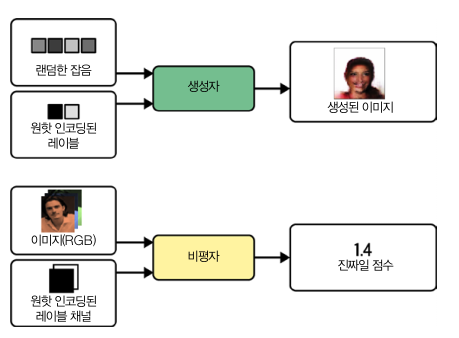

In [1]:
# GAN과 CGAN의 주요한 차이점  : 레이블관련 추가 정보를 생성자와 비평자에게 전달
# 참고 소스 : https://keras.io/examples/generative/conditional_gan/
# 원본 데이터 : https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/code
# 공유폴더 : https://drive.google.com/drive/folders/1amdDBgl7fuv9g92jSlq7mFFYUWs7AsD-?usp=sharing

In [ ]:
!unzip '/content/drive/MyDrive/celeba_face/celebA.zip'

In [2]:
from glob import glob

In [21]:
temp = glob("/content/img_align_celeba/img_align_celeba/*")
temp[:5]

['/content/img_align_celeba/img_align_celeba/140206.jpg',
 '/content/img_align_celeba/img_align_celeba/018991.jpg',
 '/content/img_align_celeba/img_align_celeba/187942.jpg',
 '/content/img_align_celeba/img_align_celeba/032345.jpg',
 '/content/img_align_celeba/img_align_celeba/124028.jpg']

In [8]:
# 라이브러리
import numpy as np
import tensorflow as tf
from tensorflow.keras import(
    layers,models,callbacks,utils,metrics,optimizers
)
# utils.py 파일 필요
from utils import display, sample_batch
import pandas as pd

In [7]:
# 파라메터
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"

In [10]:
attributes = pd.read_csv('list_attr_celeba.csv')
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [16]:
int_labels = [1 if i== 1 else 0 for i in attributes[LABEL] ]
int_labels[-5:]

[1, 1, 0, 0, 1]

In [22]:
train_data = utils.image_dataset_from_directory(
   '/content/img_align_celeba/img_align_celeba/',
   labels=int_labels,
   color_mode='rgb',
   image_size = (IMAGE_SIZE,IMAGE_SIZE),
   batch_size = BATCH_SIZE,
   shuffle=True,
   seed=42
)

Found 202599 files belonging to 2 classes.


In [24]:
# 데이터 전처리  라벨링 때문에 onehot
def preprocess(img):
  img = (tf.cast(img,'float32')-127.5) / 127.5
  return img

train = train_data.map( lambda x,y : (preprocess(x), tf.one_hot(y,depth=CLASSES)) )

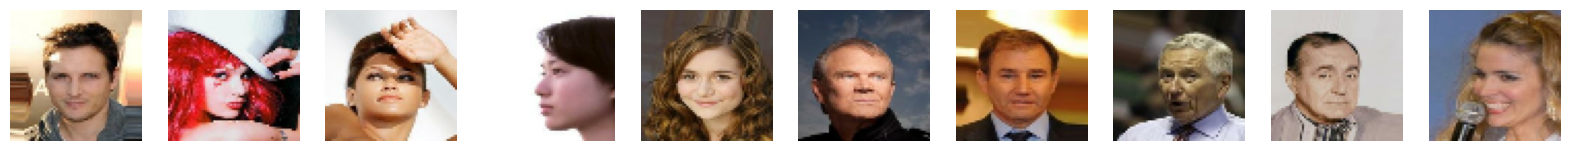

In [27]:
train_sample = sample_batch(train)
display(train_sample)

In [29]:
# 판별자... 비평자
critic_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CLASSES))
x = layers.Concatenate(axis=-1)([critic_input,label_input])

x = layers.Conv2D(64,kernel_size=4, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128,kernel_size=4, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128,kernel_size=4, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128,kernel_size=4, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(1,kernel_size=4, strides=1,padding='valid')(x)
critic_output = layers.Flatten()(x)
critc = models.Model([critic_input,label_input]  ,critic_output)
critc.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 64, 64, 2)]          0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 64, 64, 5)            0         ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 32, 32, 64)           5184      ['concatenate_1[0][0]'] 

In [30]:
generator_input = layers.Input(shape = (Z_DIM,))
label_input = layers.Input(shape=(CLASSES,))
x = layers.Concatenate(axis=-1)([generator_input,label_input])

x = layers.Reshape( (1,1,Z_DIM+CLASSES))(x)
x = layers.Conv2DTranspose(128,kernel_size=4, strides=1,padding='valid',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128,kernel_size=4, strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128,kernel_size=4, strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64,kernel_size=4, strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(CHANNELS,kernel_size=4, strides=2,padding='same',activation='tanh')(x)
generator = models.Model([generator_input,label_input],generator_output)
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 concatenate_2 (Concatenate  (None, 34)                   0         ['input_5[0][0]',             
 )                                                                   'input_6[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 1, 1, 34)             0         ['concatenate_2[0][0]'] 